# Fine tuning with S-BERT

The models will be saved in this folder - https://drive.google.com/drive/folders/1ui5rywdrDdbBUeHph9AaA0VpfX01bbRe?usp=sharing


# Setup

In [ ]:
# Install necessary libraries
! pip install --quiet \
  scprep\
  spacy==3.0.5 \
  sentence_transformers==1.0.2 \
  phate==1.0.7 && \
  python -m spacy download es_core_news_lg

! pip install --quiet wandb
# Setup connection with your own google drive
from google.colab import drive
drive.mount('/content/drive')

# Restarting the runtime is required for the libraries to be active in the notebook
import os
os.kill(os.getpid(), 9)

In [1]:
# Clone branch from github
!rm -rf policy-data-analyzer/
! branch_name='wandb-experiments' && \
  git clone --branch $branch_name https://github.com/wri-dssg/policy-data-analyzer.git

Cloning into 'policy-data-analyzer'...
remote: Enumerating objects: 875, done.
remote: Counting objects: 100% (875/875), done.
remote: Compressing objects: 100% (390/390), done.
remote: Total 5549 (delta 573), reused 756 (delta 483), pack-reused 4674
Receiving objects: 100% (5549/5549), 206.02 MiB | 7.07 MiB/s, done.
Resolving deltas: 100% (2884/2884), done.
Checking out files: 100% (1144/1144), done.


In [2]:
#If you run this cell more than once, comment out this line because you are already in this folder and you will get an error
import os
os.chdir("policy-data-analyzer") 

from tasks.fine_tuning_sbert.src.loops import *

Using the GPU


# Data Loading

In [3]:
"""
MAKE SURE THAT THIS IS ALWAYS YOUR INDIVIDUAL NUMBER (FOR REASONS TO NOT OVERWRITE DATA)
"""

GLOBAL_EXPERIMENT_NUMBER = 9

In [4]:
experiment = "EXP30"
classifier = "Binary"

base_path = "/content/drive/MyDrive/WRI-LatinAmerica-Talent"

data_path = f"{base_path}/Cristina_Policy_Files/Tagged_sentence_lists/Spanish/datasets/{classifier}"

results_save_path = f"{base_path}/Modeling/Model_reproducibility/Model_results/{classifier}ClassificationExperiments/{GLOBAL_EXPERIMENT_NUMBER}"

if not os.path.exists(results_save_path):
    os.makedirs(results_save_path)
    print(f"Making new experiment folder for experiment # {GLOBAL_EXPERIMENT_NUMBER}")
else:
    print("Please do not overwrite existing models and their results from previous experiments")
    print(f"You are writing to Experiment # {GLOBAL_EXPERIMENT_NUMBER}")

train_sents, train_labels, test_sents, test_labels = load_dataset(data_path, experiment)
label_names = unique_labels(train_labels)
numeric_train_labels = labels2numeric(train_labels, label_names)

plot_data_distribution(numeric_train_labels, label_names)

Making new experiment folder for experiment # 9


# Grid Search Fine Tuning

Stores only the parameters used in the grid search, together with the results - no model is stored

Grid Search Fine tuning parameters:
{
    "all_dev_perc": [
        0.2
    ],
    "model_names": [
        "paraphrase-xlm-r-multilingual-v1"
    ],
    "output_path": "/content/drive/MyDrive/WRI-LatinAmerica-Talent/Modeling/Model_reproducibility/Model_results/BinaryClassificationExperiments/9/",
    "experiment": 9,
    "max_num_epochs": 10,
    "baseline": 0.001,
    "patience": 5,
    "seeds": [
        12
    ],
    "eval_classifier": "SBERT"
}


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 30.41it/s]


Stored confusion matrix: /content/drive/MyDrive/WRI-LatinAmerica-Talent/Modeling/Model_reproducibility/Model_results/BinaryClassificationExperiments/9//SBERT_model=paraphrase-xlm-r-multilingual-v1_test-perc=0.2_n-epoch=10_seed=12_cm.png


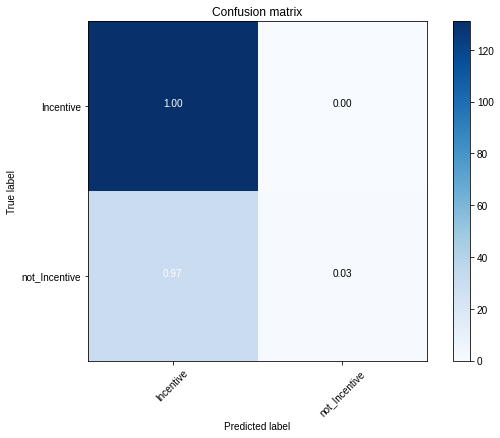

Current Score is: 0.8148148148148148
Current ACC_LIST is: [1e-06, 0.8148148148148148]
Epoch: 0
Best score: 0.8148148148148148


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 30.70it/s]


Stored confusion matrix: /content/drive/MyDrive/WRI-LatinAmerica-Talent/Modeling/Model_reproducibility/Model_results/BinaryClassificationExperiments/9//SBERT_model=paraphrase-xlm-r-multilingual-v1_test-perc=0.2_n-epoch=10_seed=12_cm.png


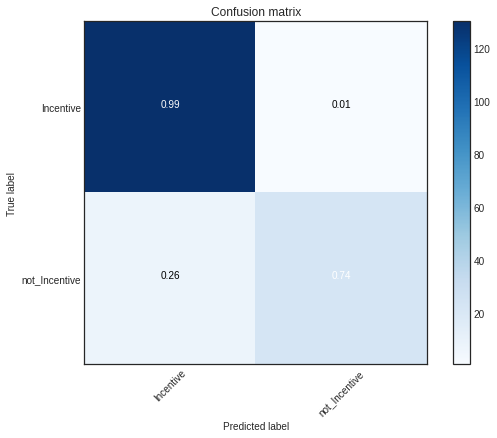

Current Score is: 0.9444444444444444
Current ACC_LIST is: [0.8148148148148148, 0.9444444444444444]
Epoch: 1
Best score: 0.9444444444444444


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 30.08it/s]


Stored confusion matrix: /content/drive/MyDrive/WRI-LatinAmerica-Talent/Modeling/Model_reproducibility/Model_results/BinaryClassificationExperiments/9//SBERT_model=paraphrase-xlm-r-multilingual-v1_test-perc=0.2_n-epoch=10_seed=12_cm.png


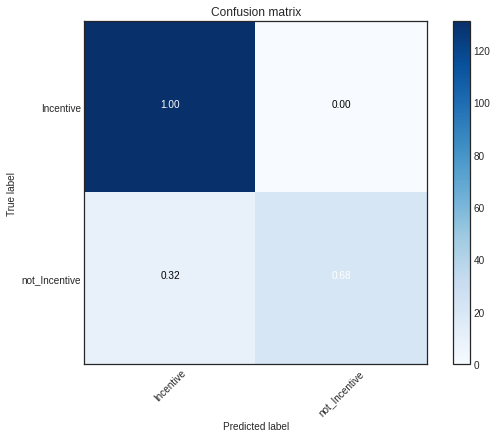

Current Score is: 0.9382716049382716
Current ACC_LIST is: [0.8148148148148148, 0.9444444444444444, 0.9382716049382716]
Epoch: 2
Best score: 0.9444444444444444


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 30.21it/s]


Stored confusion matrix: /content/drive/MyDrive/WRI-LatinAmerica-Talent/Modeling/Model_reproducibility/Model_results/BinaryClassificationExperiments/9//SBERT_model=paraphrase-xlm-r-multilingual-v1_test-perc=0.2_n-epoch=10_seed=12_cm.png


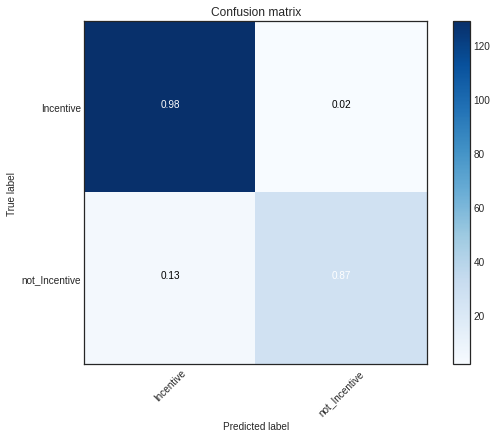

Current Score is: 0.9629629629629629
Current ACC_LIST is: [0.8148148148148148, 0.9444444444444444, 0.9382716049382716, 0.9629629629629629]
Epoch: 3
Best score: 0.9629629629629629


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 31.15it/s]


Stored confusion matrix: /content/drive/MyDrive/WRI-LatinAmerica-Talent/Modeling/Model_reproducibility/Model_results/BinaryClassificationExperiments/9//SBERT_model=paraphrase-xlm-r-multilingual-v1_test-perc=0.2_n-epoch=10_seed=12_cm.png


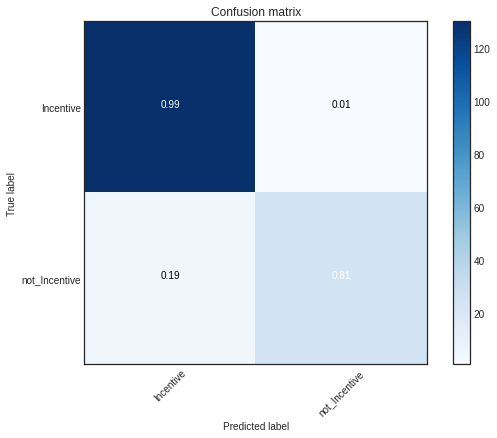

Current Score is: 0.9567901234567902
Current ACC_LIST is: [0.8148148148148148, 0.9444444444444444, 0.9382716049382716, 0.9629629629629629, 0.9567901234567902]
Epoch: 4
Best score: 0.9629629629629629


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 28.55it/s]


Stored confusion matrix: /content/drive/MyDrive/WRI-LatinAmerica-Talent/Modeling/Model_reproducibility/Model_results/BinaryClassificationExperiments/9//SBERT_model=paraphrase-xlm-r-multilingual-v1_test-perc=0.2_n-epoch=10_seed=12_cm.png


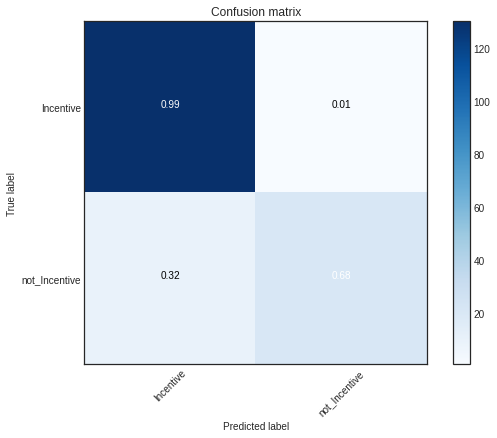

Current Score is: 0.9320987654320988
Current ACC_LIST is: [0.8148148148148148, 0.9444444444444444, 0.9382716049382716, 0.9629629629629629, 0.9567901234567902, 0.9320987654320988]
Epoch: 5
Best score: 0.9629629629629629


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 30.59it/s]


Stored confusion matrix: /content/drive/MyDrive/WRI-LatinAmerica-Talent/Modeling/Model_reproducibility/Model_results/BinaryClassificationExperiments/9//SBERT_model=paraphrase-xlm-r-multilingual-v1_test-perc=0.2_n-epoch=10_seed=12_cm.png


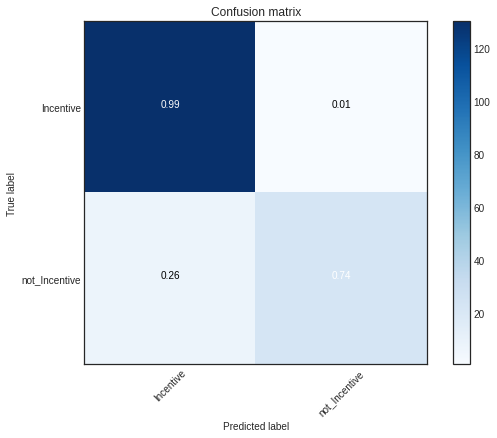

Current Score is: 0.9444444444444444
Current ACC_LIST is: [0.8148148148148148, 0.9444444444444444, 0.9382716049382716, 0.9629629629629629, 0.9567901234567902, 0.9320987654320988, 0.9444444444444444]
Current score (0.9444444444444444) less than moving average (0.9469135802469135)
TRAINING EXITED. Best model has been found.
Epoch: 6
Best score: 0.9629629629629629


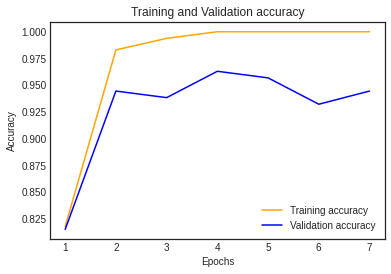

Time taken for fine-tuning: 00:01:14.36


In [7]:
grid_search_params = {
    "all_dev_perc": [0.2],# 0.15, 0.25, 0.3],
    "model_names": ['paraphrase-xlm-r-multilingual-v1'], #'stsb-xlm-r-multilingual', 'quora-distilbert-multilingual''distiluse-base-multilingual-sed-v2',
    "output_path": results_save_path,
    "max_num_epochs": 10,
    "baseline": 0.001,
    "patience": 5,
    "seeds": [12]
}

grid_search_fine_tune_sbert(grid_search_params, train_sents, train_labels, label_names)

## Loading saved model

In [ ]:
saved_model = EarlyStoppingSentenceTransformer(model_name_or_path=results_save_path)
str(saved_model)

'EarlyStoppingSentenceTransformer(\n  (0): Transformer(\n    (auto_model): XLMRobertaModel(\n      (embeddings): RobertaEmbeddings(\n        (word_embeddings): Embedding(250002, 768, padding_idx=1)\n        (position_embeddings): Embedding(514, 768, padding_idx=1)\n        (token_type_embeddings): Embedding(1, 768)\n        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)\n        (dropout): Dropout(p=0.1, inplace=False)\n      )\n      (encoder): RobertaEncoder(\n        (layer): ModuleList(\n          (0): RobertaLayer(\n            (attention): RobertaAttention(\n              (self): RobertaSelfAttention(\n                (query): Linear(in_features=768, out_features=768, bias=True)\n                (key): Linear(in_features=768, out_features=768, bias=True)\n                (value): Linear(in_features=768, out_features=768, bias=True)\n                (dropout): Dropout(p=0.1, inplace=False)\n              )\n              (output): RobertaSelfOutput(\n          

## Testing model on evaluation set

In [ ]:
model_name = 'paraphrase-xlm-r-multilingual-v1'
dev_perc = 0.2
num_epochs  = 8
seed = 12
model_deets = f"SBERT_model={model_name}_test-perc={dev_perc}_seed={seed}_n-epochs={num_epochs}"
numeric_test_labels = labels2numeric(test_labels, label_names)
evaluate_using_sbert(model, test_sents, test_labels, label_names,
                         model_deets, numeric_test_labels, output_path=results_save_path)

## Define evaluation classifier (optional)
If using a sklearn or other non-SBERT model as a classifier for evaluation, uncomment one of these models (or add your own and name it `clf`)

In [ ]:
from lightgbm import LGBMClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

In [ ]:
clf = LGBMClassifier(n_estimators=2000,
                      feature_fraction=0.06,
                      bagging_fraction=0.67,
                      bagging_freq=1,
                      verbose=0,
                      n_jobs=6,
                      random_state=69420)

clf = svm.SVC(gamma=0.001, C=100.)

clf = RandomForestClassifier(n_estimators=500,
                            max_features=0.06,
                            n_jobs=6,
                            random_state=69420)